In [1]:
rm(list=ls())
set.seed(2018)
n <- 2000
p <- 500
x <- matrix( rnorm(n*p), n )
y <- rnorm(n)

In [2]:
system.time( lm(y ~ 0 + x) )

   user  system elapsed 
   0.37    0.00    0.37 

### 回归公式的复杂度

* 回归公式: $\hat{y} = x (x'x)^{-1} x' y$.
* $A_{m \times n} B_{n \times r}$ 的复杂度为 $m n^2 r$.
* 从左向右计算的复杂度为 $np^2 + np^2 + n^2p + n^2$.
* 从右向左计算的复杂度为 $np + np^2 + p^2 + np$.

In [3]:
f1 <- function(x, y) x %*% solve(t(x) %*% x) %*% t(x) %*% y
f2 <- function(x, y) x %*% (solve(t(x) %*% x) %*% (t(x) %*% y))
system.time( f1(x, y) )

   user  system elapsed 
   2.20    0.00    2.21 

In [4]:
system.time( f2(x, y) )

   user  system elapsed 
   0.45    0.00    0.45 

### 进一步改进:

* $x'x$ 是对称矩阵, 在矩阵乘法中只需要计算一般元素, 利用 `crossprod` 实现.
* 避免显式转置: `crossprod(x, y)` 等价于 `x'y`.
* 避免显式传递: `solve(A, b)` 等价于 `A^{-1} b`.

In [5]:
f3 <- function(x, y) x %*% solve( crossprod(x), crossprod(x, y))
system.time(f3)

   user  system elapsed 
      0       0       0 

### 更实际的做法: 利用 `QR` 分解

* `QR` 分解: $X = QR$, 其中 $Q'Q = I$, $R$ 为上三角矩阵. $\hat{y} = x (x'x)^{-1} x'y = Q Q' y$.
* `QR` 分解的内置函数非常丰富, 可以计算分解结果及其涉及的相关计算. 例如, `qr.qy()` 和 `qr.qty()` 分别用于计算 $Qy$ 和 $Q'y$, 这比用公式计算的效率高很多.

In [6]:
f4 <- function(x, y){
    tmp <- qr(x)
    qr.qy(tmp, qr.qty(tmp, y))
}
system.time( f4(x, y) )

   user  system elapsed 
   0.36    0.00    0.36 

### 另一种方法是使用 `Choleskey` 分解.

`Choleskey` 分解: 正定矩阵 $A = x' x$ 可分解为 $A = L L'$, 其中 $L$ 为下三角矩阵. 此时 $\hat{y} = X (L')^{-1} L^{-1} X' y$, 其中涉及三角矩阵求逆, 可以用 `backsolve` / `forwardsolve` 计算上三角或下三角方程组.

In [7]:
f5 <- function(x, y) {
    u <- chol(crossprod(x))
    lxy <- backsolve(u, crossprod(x, y), transpose=TRUE)
    x %*% backsolve(u, lxy)
}
system.time( f5(x, y) )

   user  system elapsed 
   0.29    0.00    0.29 

### `QR` 的特点
* 算法稳定, 精度高.
* 允许变量的多重共线性.
* 是大部分统计软件的算法.
* 复杂度约为 $2np^2 - 3p^3 / 2$.

### `Choleskey` 的特点:
* 速度快, 精度不如 `QR`.
* 易于并行.
* 计算量约为 $np^2 + p^3 / 3 + O(p^2)$

由于 Cholesky 分解前要先计算 $X'X$, 如果 $X$ 有多重共线性的话, 得到的 $L$ 是不可逆的, 全程可能损失较大的精度. 如果 $n >> p$, QR 的计算量大约是 Cholesky 的两倍. 如果 $p$ 较大的话, QR 分解的计算量不会差很多. 当 $p$ 比 $n$ 大的时候, 上面的方法都是不能直接应用的, 此时 $\hat{y}$ 唯一, 但是系数向量估计值不唯一. 比如 QR 分解中的矩阵 $Q$ 就不能满足列正交. 这时候需要一些花式解法, 比如
* LDL (类似 Cholesky)
* SVD
* CG (共轭梯度法, 适用于稀疏矩阵)
* ...

**根据需要选择恰当的算法, 要考虑侧重点是稳定还是效率.**

另外, 除了上面提到的计算方法上的改进, 在具体实现上可以选择更高效的方式, 比如 `RcppEigen` 提供的 `fastLm()` / `fastLmPure()` 两个函数, 它们的算法和上面一样, 但是效率更高, 函数中的参数 `method` 提供了多种计算方法.

In [8]:
library(RcppEigen)
system.time( fastLm(x, y) )
system.time( fastLmPure(x, y) )

   user  system elapsed 
   0.15    0.04    0.20 

   user  system elapsed 
   0.17    0.00    0.17 

## 完整的对比

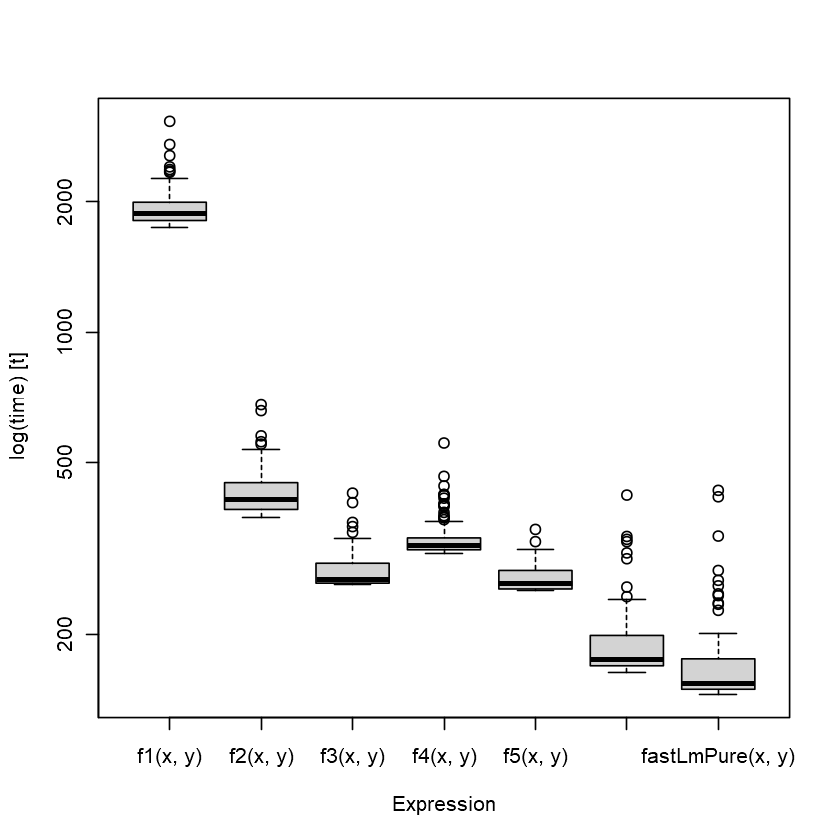

In [9]:
library(microbenchmark)
microbenchmark(
    f1(x, y),
    f2(x, y),
    f3(x, y),
    f4(x, y),
    f5(x, y),
    fastLm(x, y),
    fastLmPure(x, y)
) |> boxplot()

In [10]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19043)

Matrix products: default

locale:
[1] LC_COLLATE=Chinese (Simplified)_China.936 
[2] LC_CTYPE=Chinese (Simplified)_China.936   
[3] LC_MONETARY=Chinese (Simplified)_China.936
[4] LC_NUMERIC=C                              
[5] LC_TIME=Chinese (Simplified)_China.936    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] microbenchmark_1.4-7 RcppEigen_0.3.3.9.1 

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.7      lattice_0.20-44 fansi_0.5.0     digest_0.6.27  
 [5] utf8_1.2.2      crayon_1.4.1    IRdisplay_1.0   grid_4.1.0     
 [9] repr_1.1.3      lifecycle_1.0.0 jsonlite_1.7.2  evaluate_0.14  
[13] pillar_1.6.1    rlang_0.4.11    uuid_0.1-4      Matrix_1.3-3   
[17] vctrs_0.3.8     ellipsis_0.3.2  IRkernel_1.2    Cairo_1.5-12.2 
[21] tools_4.1.0     fastmap_1.1.0   compiler_4.1.0  ba